## Load Package and Set path for R-markdown document

In [1]:
library("sp")
library("rJava")
library("raster")
library("dismo")
library("rgeos")
 
library("geojsonio")


rgeos version: 0.6-1, (SVN revision 692)
 GEOS runtime version: 3.11.1-CAPI-1.17.1 
 Please note that rgeos will be retired during 2023,
plan transition to sf functions using GEOS at your earliest convenience.
 GEOS using OverlayNG
 Linking to sp version: 1.5-1 
 Polygon checking: TRUE 


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.0; sf_use_s2() is TRUE

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty




In [2]:
library("knitr")
library("rprojroot")

In [3]:
knitr::opts_knit$set(root.dir = '/home/jupyter/MyData/MaxEnt')
opts_chunk$set(tidy.opts=list(width.cutoff=60),tidy=TRUE)

## Set up MaxEnt Path

In [4]:
utils::download.file(url = "https://raw.githubusercontent.com/mrmaxent/Maxent/master/ArchivedReleases/3.3.3k/maxent.jar", 
    destfile = paste0(system.file("java", package = "dismo"), 
        "/maxent.jar"), mode = "wb")  ## wb for binary file, otherwise maxent.jar can not execute

2.1 Load environmental layers In our example, we use bioclimatic variables (downloaded from worldclim.org) as input environmental layers. We stack our environmental layers so that they can be processed simultaneously.

In [5]:
# prepare folders for data input and output
if (!file.exists("/home/jupyter/MyData/MaxEnt/data")) dir.create("/home/jupyter/MyData/MaxEnt/data")
if (!file.exists("/home/jupyter/MyData/MaxEnt/data/bioclim")) dir.create("/home/jupyter/MyData/MaxEnt/data/bioclim")
if (!file.exists("/home/jupyter/MyData/MaxEnt/data/studyarea")) dir.create("/home/jupyter/MyData/MaxEnt/data/studyarea")
if (!file.exists("/home/jupyter/MyData/MaxEnt/output")) dir.create("/home/jupyter/MyData/MaxEnt/output")
require(utils)


In [6]:
clim_list_before <- list.files("/home/jupyter/MyData/historical_data/before_align/", pattern = '.tif', full.names = T)  # '..' leads to the path above the folder where the .rmd file is located
clim_list_before

[1] "/home/jupyter/MyData/historical_data/before_align//barren.tif"            
[2] "/home/jupyter/MyData/historical_data/before_align//cropland.tif"          
[3] "/home/jupyter/MyData/historical_data/before_align//forest.tif"            
[4] "/home/jupyter/MyData/historical_data/before_align//grassland.tif"         
[5] "/home/jupyter/MyData/historical_data/before_align//permanent_snow_ice.tif"
[6] "/home/jupyter/MyData/historical_data/before_align//urban.tif"             
[7] "/home/jupyter/MyData/historical_data/before_align//water.tif"

In [8]:

startTime <- Sys.time()

for (file_name in clim_list_before){
    print(file_name)
    r1 <- raster(file_name)
    r2 <- raster("/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_AHM.tif")
    r1 <- resample(r1,r2, "bilinear")
    r1 <- mask(r1, r2)
    this_file_name <- strsplit(file_name, split = "//")[[1]][2]
    file_save_path <- paste("/home/jupyter/MyData/historical_data/",this_file_name,sep = '')
    writeRaster(r1, filename = file_save_path, format = "GTiff",overwrite=TRUE)
}


endTime <- Sys.time()
print(endTime-startTime)

[1] "/home/jupyter/MyData/historical_data/before_align//barren.tif"
[1] "/home/jupyter/MyData/historical_data/before_align//cropland.tif"
[1] "/home/jupyter/MyData/historical_data/before_align//forest.tif"
[1] "/home/jupyter/MyData/historical_data/before_align//grassland.tif"
[1] "/home/jupyter/MyData/historical_data/before_align//permanent_snow_ice.tif"
[1] "/home/jupyter/MyData/historical_data/before_align//urban.tif"
[1] "/home/jupyter/MyData/historical_data/before_align//water.tif"
Time difference of 32.16713 mins


In [11]:
# This searches for all files that are in the path
# 'data/bioclim/' and have a file extension of .bil. You can
# edit this code to reflect the path name and file extension
# for your environmental variables
clim_list <- list.files("/home/jupyter/MyData/historical_data/", pattern = '.tif$', 
    full.names = T)  # '..' leads to the path above the folder where the .rmd file is located

print(clim_list)

 [1] "/home/jupyter/MyData/historical_data//barren.tif"                           
 [2] "/home/jupyter/MyData/historical_data//cropland.tif"                         
 [3] "/home/jupyter/MyData/historical_data//forest.tif"                           
 [4] "/home/jupyter/MyData/historical_data//grassland.tif"                        
 [5] "/home/jupyter/MyData/historical_data//permanent_snow_ice.tif"               
 [6] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_AHM.tif"    
 [7] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_CMD.tif"    
 [8] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_CMI.tif"    
 [9] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_DD_0.tif"   
[10] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_DD_18.tif"  
[11] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_DD1040.tif" 
[12] "/home/jupyter/MyData/historical_data//resample_Normal_1991_2020_DD18.tif"   
[13]

In [12]:
# stacking the bioclim variables to process them at one go
clim <- raster::stack(clim_list)

In [13]:
clim

class      : RasterStack 
dimensions : 7788, 36000, 280368000, 25  (nrow, ncol, ncell, nlayers)
resolution : 0.01, 0.01  (x, y)
extent     : -180, 180, 6.251504, 84.1315  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : barren, cropland, forest, grassland, permanent_snow_ice, resample_//1_2020_AHM, resample_//1_2020_CMD, resample_//1_2020_CMI, resample_//_2020_DD_0, resample_//2020_DD_18, resample_//020_DD1040, resample_//_2020_DD18, resample_//_2020_eFFP, resample_//1_2020_EMT, resample_//_2020_Eref, ... 
min values :      0,        0,      0,         0,                  0,                     ?,                     ?,                     ?,                     ?,                     ?,                     ?,                     ?,                     ?,                     ?,                     ?, ... 
max values :      1,        1,      1,         1,                  1,                     ?,                     ?,                     ?,      

In [14]:
names(clim)

[1] "barren"                            "cropland"                         
 [3] "forest"                            "grassland"                        
 [5] "permanent_snow_ice"                "resample_Normal_1991_2020_AHM"    
 [7] "resample_Normal_1991_2020_CMD"     "resample_Normal_1991_2020_CMI"    
 [9] "resample_Normal_1991_2020_DD_0"    "resample_Normal_1991_2020_DD_18"  
[11] "resample_Normal_1991_2020_DD1040"  "resample_Normal_1991_2020_DD18"   
[13] "resample_Normal_1991_2020_eFFP"    "resample_Normal_1991_2020_EMT"    
[15] "resample_Normal_1991_2020_Eref"    "resample_Normal_1991_2020_EXT"    
[17] "resample_Normal_1991_2020_FFP"     "resample_Normal_1991_2020_MCMT"   
[19] "resample_Normal_1991_2020_PPT_sm"  "resample_Normal_1991_2020_PPT_wt" 
[21] "resample_Normal_1991_2020_Tave_at" "resample_Normal_1991_2020_Tave_sp"
[23] "resample_Normal_1991_2020_TD"      "urban"                            
[25] "water"

## 2.2 Occurrence data

In [15]:
if (file.exists("/home/jupyter/MyData/MaxEnt/data/occ_raw")) {
    load("/home/jupyter/MyData/MaxEnt/data/occ_raw")
} else {
    print("create new file")
    occ_raw <- read.csv("/home/jupyter/MyData/MaxEnt/data/San_rarefied_points.csv")
    save(occ_raw, file = "/home/jupyter/MyData/MaxEnt/data/occ_raw")
}

0 records are removed0 records are removed

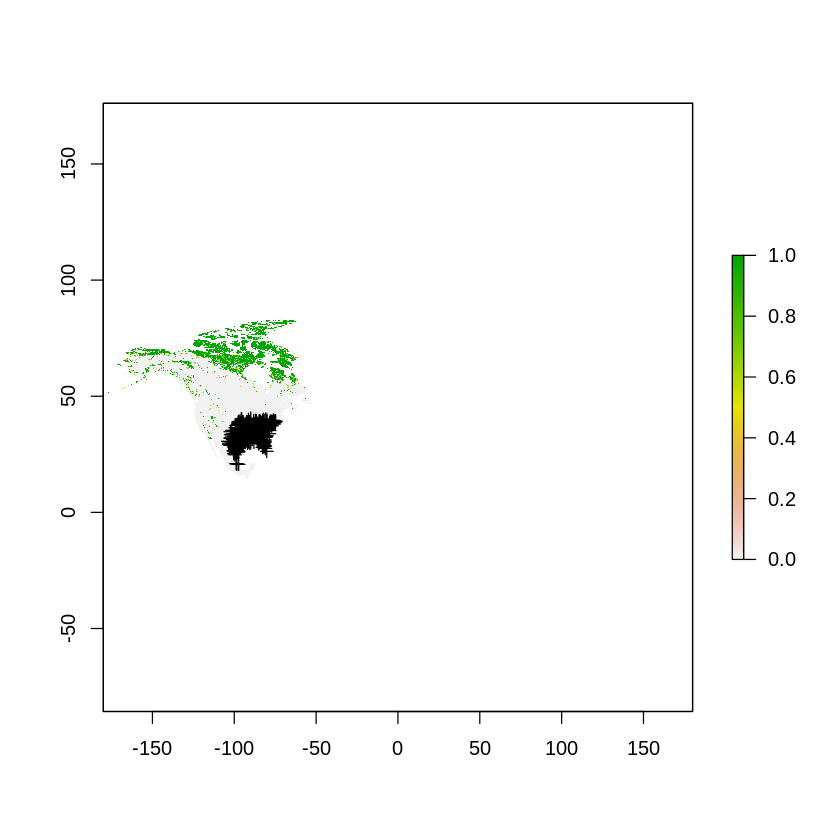

In [16]:
occ_clean <- subset(occ_raw, (!is.na(latitudes)) & (!is.na(longitudes)))  #  '!' means the opposite logic value
cat(nrow(occ_raw) - nrow(occ_clean), "records are removed")
# remove duplicated data based on latitude and longitude
dups <- duplicated(occ_clean[c("latitudes", "longitudes")])
occ_unique <- occ_clean[!dups, ]
cat(nrow(occ_clean) - nrow(occ_unique), "records are removed")
# make occ spatial
coordinates(occ_unique) <- ~longitudes + latitudes
## look for erroneous points
plot(clim[[1]])  # to the first layer of the bioclim layers as a reference
plot(occ_unique, add = TRUE)  # plot the oc_unique on the above raster layer

In [17]:
# thin occ data (keep one occurrence point per cell)
cells <- cellFromXY(clim[[1]], occ_unique)
dups <- duplicated(cells)
occ_final <- occ_unique[!dups, ]
cat(nrow(occ_unique) - nrow(occ_final), "records are removed")

0 records are removed

In [18]:
proj4string(occ_final)<- CRS("+init=epsg:4326")

Up to this point we have been working with a data frame, but it has no spatial relationship with environmental layers. So we need to make the data spatial. Once our data is spatial we can use the plot function to see the occurrence data and allow us to check for data points that appear to be erroneous.

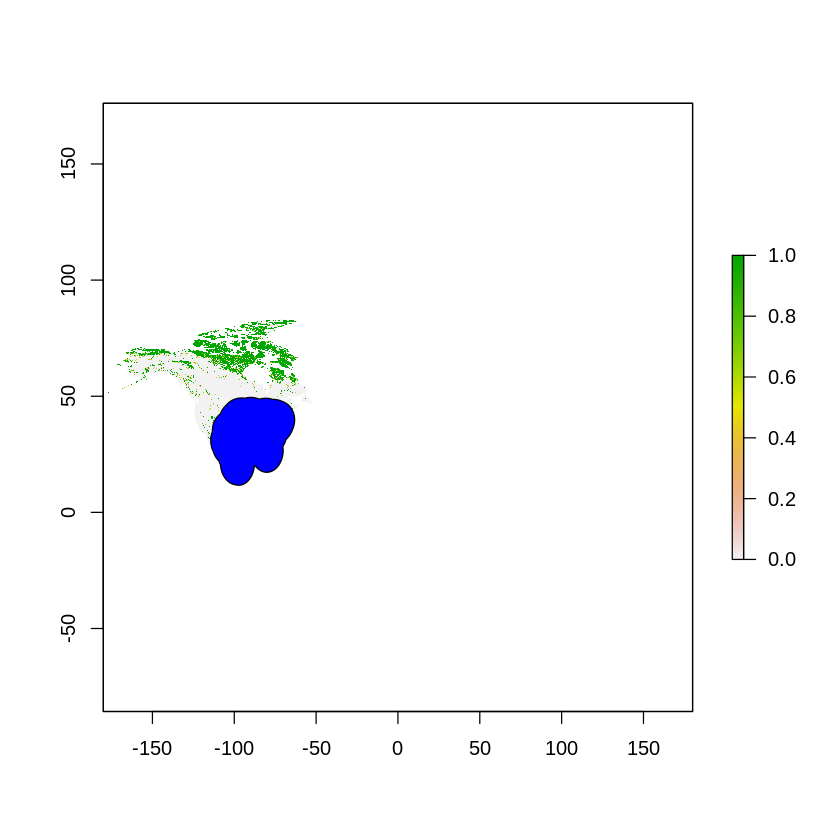

In [19]:
# this creates a 4-decimal-degree buffer around the
# occurrence data
occ_buff <- buffer(occ_final, 1000000)

# plot the first element ([[1]]) in the raster stack
plot(clim[[1]])

plot(occ_final, add = T, col = "red")  # adds occurrence data to the plot
plot(occ_buff, add = T, col = "blue")  # adds buffer polygon to the plot

In [20]:
# crop study area to a manageable extent (rectangle shaped)
startTime <- Sys.time()

studyArea <- crop(clim,extent(occ_buff))  

# the 'study area' created by extracting the buffer area from the raster stack
studyArea <- mask(studyArea,occ_buff)
# output will still be a raster stack, just of the study area

# save the new study area rasters as ascii
writeRaster(studyArea,
            # a series of names for output files
            filename=paste0("/home/jupyter/MyData/MaxEnt/data/studyarea/",names(studyArea),".asc"), 
            format="ascii", ## the output format
            bylayer=TRUE, ## this will save a series of layers
            overwrite=T)

endTime <- Sys.time()
print(endTime-startTime)

Time difference of 14.15758 mins


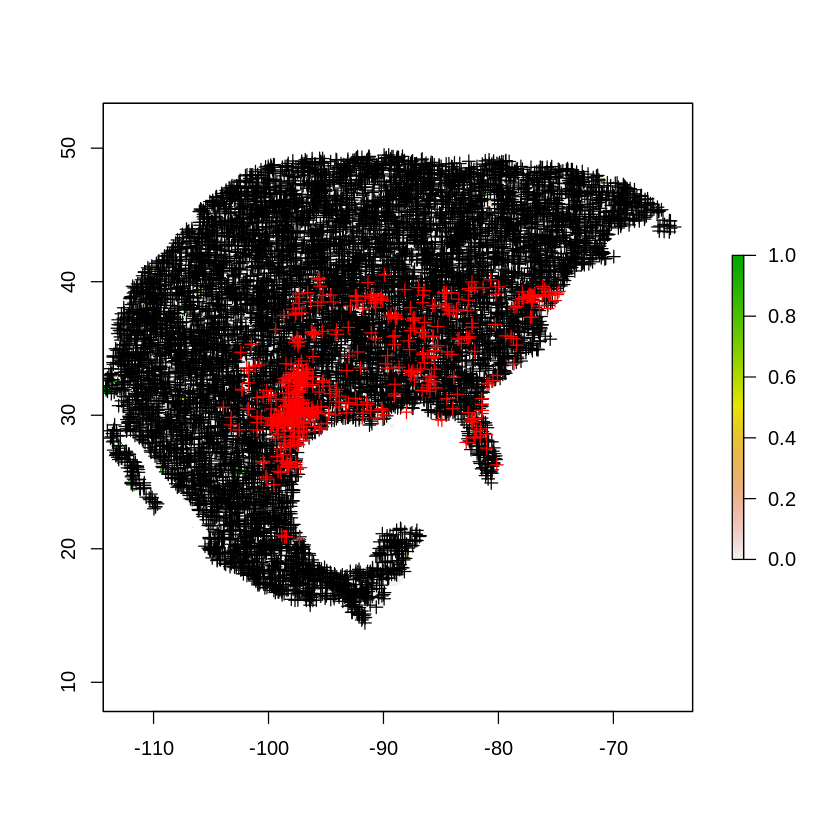

In [21]:
# select background points from this buffered area; when the number provided 
# to set.seed() function, the same random sample will be selected in the next line			
# use this code before the sampleRandom function every time, if you want to get
# the same "random samples"
set.seed(1) 
bg <- sampleRandom(x=studyArea,
                   size=10000,
                   na.rm=T, #removes the 'Not Applicable' points  
                   sp=T) # return spatial points 

plot(studyArea[[1]])
# add the background points to the plotted raster
plot(bg,add=T) 
# add the occurrence data to the plotted raster
plot(occ_final,add=T,col="red")

###2.4 Split occurrence data into training & testing We randomly selected 50% of the occurrence data for model training and used the remaining for model testing. To make our experiment reproducible (i.e., select the same set of points), we used a static seed via set.seed(1) function.

In [22]:
# get the same random sample for training and testing
set.seed(1)

# randomly select 50% for training
selected <- sample(1:nrow(occ_final), nrow(occ_final) * 0.5)

occ_train <- occ_final[selected, ]  # this is the selection to be used for model training
occ_test <- occ_final[-selected, ]  # this is the opposite of the selection which will be used for model testing

###2.5 Format data for Maxent The data input can either be spatial or tabular. In our example, we use the tabular format, which can be potentially more flexible. We extract environmental conditions for background, training, and testing points in a dataframe format.



In [23]:
# extracting env conditions for training occ from the raster
# stack; a data frame is returned (i.e multiple columns)
p <- extract(clim, occ_train)
# env conditions for testing occ
p_test <- extract(clim, occ_test)
# extracting env conditions for background
a <- extract(clim, bg)

Maxent reads a "1" as presence and "0" as pseudo-absence. Thus, we need to assign a "1" to the training environmental conditions and a "0" for the background. We create a set of rows with the same number as the training and testing data, and put the value of "1" for each cell and a "0" for background. We combine the "1"s and "0"s into a vector that was added to the dataframe containing the environmental conditions associated with the testing and background conditions.

In [24]:
# repeat the number 1 as many numbers as the number of rows
# in p, and repeat 0 as the rows of background points
pa <- c(rep(1, nrow(p)), rep(0, nrow(a)))

# (rep(1,nrow(p)) creating the number of rows as the p data
# set to have the number '1' as the indicator for presence;
# rep(0,nrow(a)) creating the number of rows as the a data
# set to have the number '0' as the indicator for absence;
# the c combines these ones and zeros into a new vector that
# can be added to the Maxent table data frame with the
# environmental attributes of the presence and absence
# locations
pder <- as.data.frame(rbind(p, a))

## 3 Maxent models ###3.1 Simple implementation

In [25]:
# train Maxent with spatial data
# mod <- maxent(x=clim,p=occ_train)
startTime <- Sys.time()
# train Maxent with tabular data
mod <- maxent(x=pder, ## env conditions
              p=pa,   ## 1:presence or 0:absence

              path=paste0("/home/jupyter/MyData/MaxEnt/output/maxent_outputs"), ## folder for maxent output; 
              # if we do not specify a folder R will put the results in a temp file, 
              # and it gets messy to read those. . .
              args=c("responsecurves","jackknife") ## parameter specification
              )
# the maxent functions runs a model in the default settings. To change these parameters,
# you have to tell it what you want...i.e. response curves or the type of features

# view the maxent model in a html brower
mod


endTime <- Sys.time()
print(endTime-startTime)

This is MaxEnt version 3.3.3k 


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Time difference of 25.5347 secs


In [26]:
mod@results

X.Training.samples,248.0000
Regularized.training.gain,1.5419
Unregularized.training.gain,1.7990
Iterations,500.0000
Training.AUC,0.9393
X.Background.points,10246.0000
barren.contribution,0.0000
cropland.contribution,0.2437
forest.contribution,0.3141
grassland.contribution,1.1442
permanent_snow_ice.contribution,0.0000


Time difference of 25.67353 mins


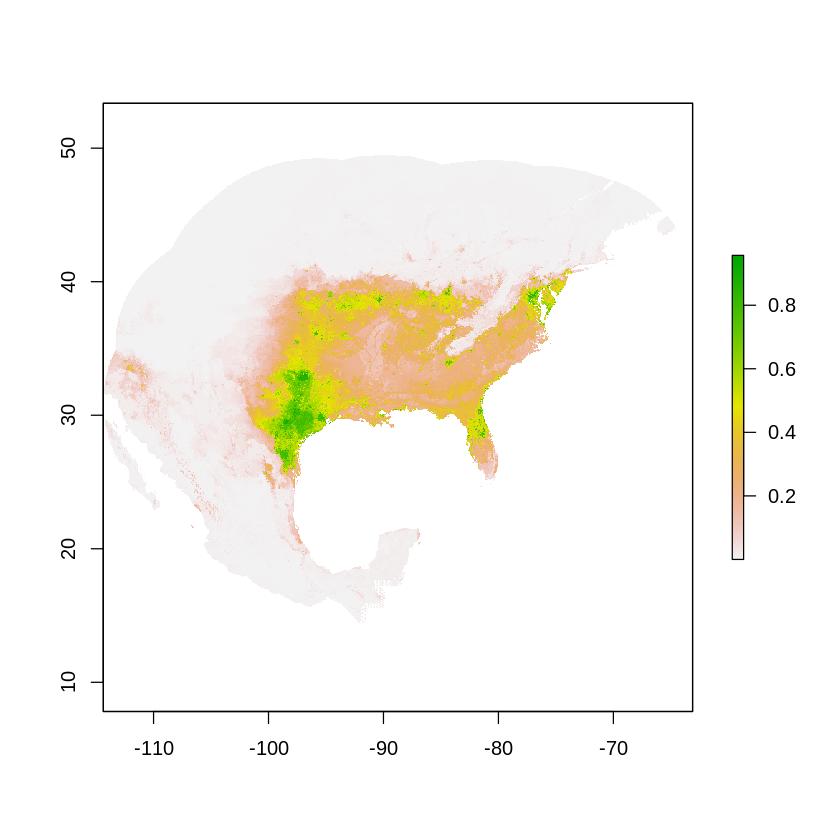

In [27]:
# example 1, project to study area [raster]
startTime <- Sys.time()

ped1 <- predict(mod, studyArea)  # studyArea is the clipped rasters 
plot(ped1)  # plot the continuous prediction
endTime <- Sys.time()
print(endTime-startTime)

Time difference of 2.726256 hours


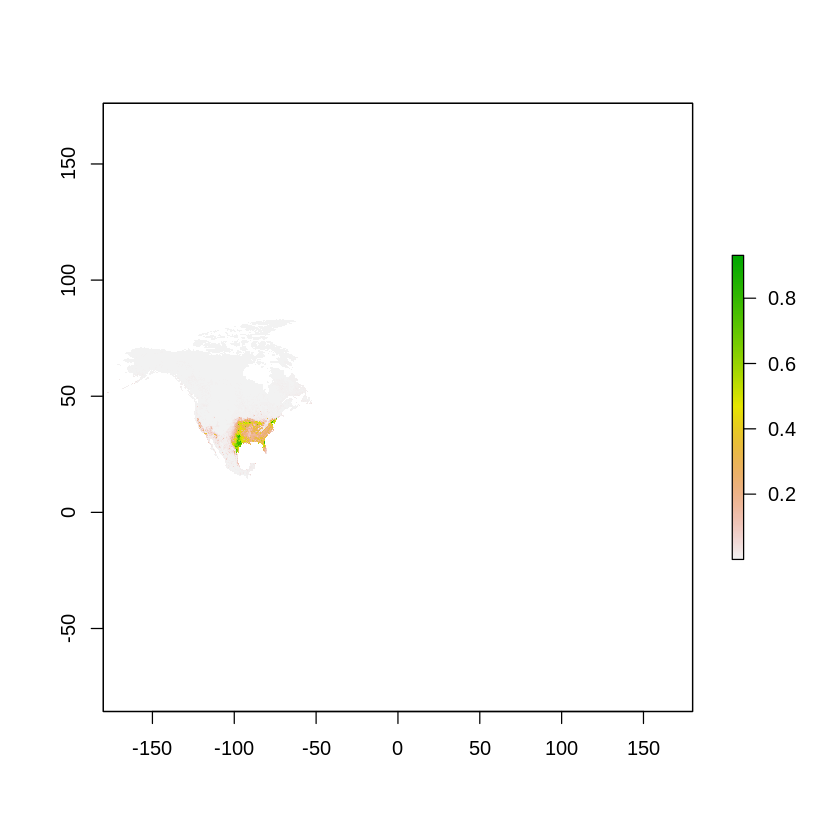

In [28]:
# example 2, project to the world 
startTime <- Sys.time()

ped2 <- predict(mod,clim)
plot(ped2)
endTime <- Sys.time()
print(endTime-startTime)



In [29]:
# example 3, project with training occurrences [dataframes]
ped3 <- predict(mod, p)
head(ped3)

[1] 0.4234412 0.7591412 0.5175434 0.4173580 0.6452733 0.7110602

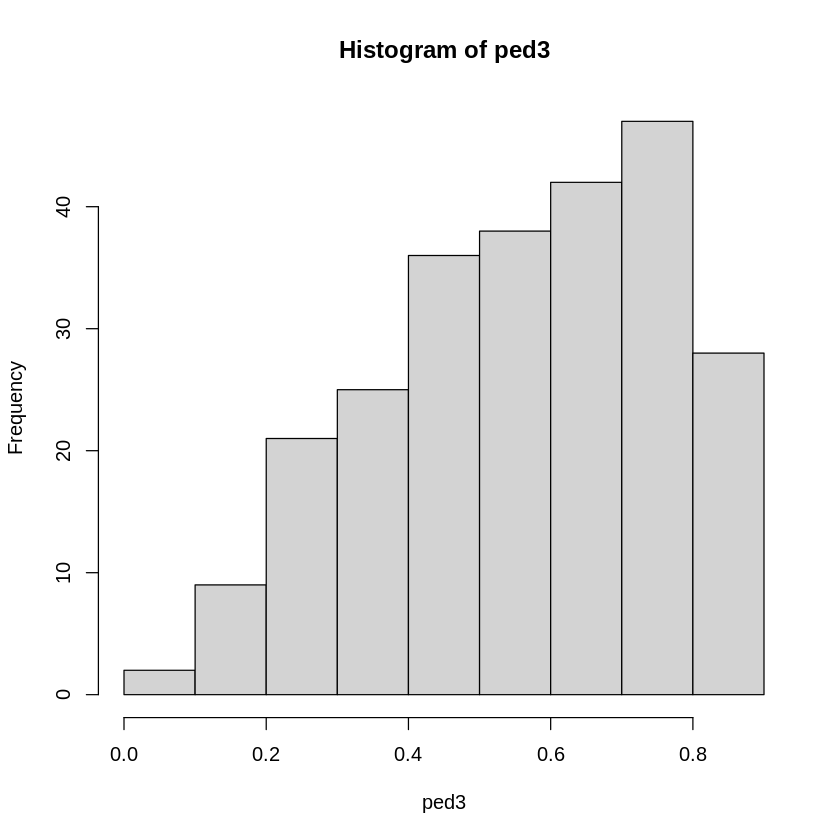

In [30]:
hist(ped3)  # creates a histogram of the prediction

In [31]:
# using 'training data' to evaluate p & a are dataframe/s
# (the p and a are the training presence and background
# points)
mod_eval_train <- dismo::evaluate(p = p, a = a, model = mod)
print(mod_eval_train)

class          : ModelEvaluation 
n presences    : 248 
n absences     : 10000 
AUC            : 0.9500621 
cor            : 0.4016382 
max TPR+TNR at : 0.2367432 


In [34]:
#save the model
typeof(mod)
mod

[1] "S4"

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

